In [1]:
import re
import os
from collections import defaultdict

import wandb
import numpy as np
from tqdm import tqdm
from omegaconf import OmegaConf as om
import matplotlib.pyplot as plt

In [2]:
api = wandb.Api()
project_name = "mosaic-ml/neural-data-filtering"

In [3]:
# # Baseline vs offline comparison
# groups = {
#     "mpt-passes-1-final-3B-52B-baseline": "baseline",
#     "mpt-passes-1-final-3B-52B-offline-hard-0.5-ref-125M-26B": "offline-global",
#     "mpt-passes-1-final-3B-52B-offline-local-hard-0.5-ref-125M-26B": "offline-local",
# }

# # PILE Baseline vs offline comparison
# groups = {
#     "pile-passes-0.5-final-1B-26B-baseline": "baseline",
#     "pile-passes-0.5-final-1B-26B-offline-global-hard-0.5-ref-125M-26B": "offline-global",
# }

# MPT commesurate step sizes
groups = {
    "mpt-passes-0.5-final-1B-26B-baseline": "baseline",
    "mpt-passes-0.5-ref-1B-26B": "ref-model",
    # "mpt-passes-0.5-final-1B-26B-offline-global-hard-0.5-ref-1B-26B": "global-hard",
    # "mpt-passes-0.5-final-1B-26B-offline-local-hard-0.5-ref-125M-26B": "local-hard",
    # "mpt-passes-0.5-final-1B-26B-offline-global-mid-0.5-ref-1B-26B": "1B-ref-global-mid",
    "mpt-passes-0.5-final-1B-26B-offline-global-mid-0.5-ref-125M-26B": "125M-ref-global-mid",
    # "mpt-passes-0.5-final-1B-26B-offline-local-mid-0.5-ref-125M-26B": "local-mid",
    # "mpt-passes-0.5-final-1B-26B-offline-web-hard-0.5-ref-1B-26B": "web-hard",
}

groups = {
    "mpt-passes-0.5-final-1B-130B-baseline": "baseline",
    "mpt-passes-0.5-final-1B-130B-offline-global-mid-0.5-ref-125M-26B": "125M-ref-global-mid",
}

groups = {
    "pile-passes-0.5-final-1B-26B-baseline": "baseline",
    "pile-passes-0.5-final-1B-26B-offline-global-hard-0.5-ref-125M-26B": "125M-ref-global-mid",
}

# # 1B comparison runs
# groups = {
#     "mpt-passes-0.5-final-1B-26B-baseline": "baseline",
#     "mpt-passes-0.5-final-1B-26B-offline-global-hard-0.5-ref-125M-26B": "125M-global-hard",
#     "mpt-passes-0.5-final-1B-26B-offline-global-hard-0.5-ref-1B-26B": "1B-global-hard",
#     "mpt-passes-0.5-final-1B-26B-offline-web-hard-0.5-ref-1B-26B": "1B-web-hard",
#     # "mpt-passes-0.5-final-1B-26B-offline-web-mid-0.5-ref-1B-26B": "1B-web-mid",
# }

# 2.5 vs 1.4 epoch comparisons
# groups = {
#     "mpt1.5-3b-params-52b-tokens-1.4x-epoch-raw-proportion": "raw-mix-5T-setting",
#     "mpt1.5-3b-params-52b-tokens-2.5x-epoch-raw-proportion": "raw-mix-10T-setting",
# }

In [4]:
raw = False
SEQ_LEN = 2048
BATCH_SIZE = 512
LR = 0.0002
SEED = 42
filters = {}

In [5]:
runs = api.runs(project_name, filters=filters)

In [6]:
categories = ["average", "world_knowledge", "commonsense_reasoning", "language_understanding", "symbolic_problem_solving", "reading_comprehension"]
metric_names = [os.path.join("icl", "metrics", f"{'raw_' if raw else ''}eval_gauntlet", category) for category in categories[1:]]

In [7]:
raw_group_results = {group: defaultdict(list) for group in groups.keys()} 
for run in tqdm(runs):
    group = run.group
    name = run.name


    if group not in groups:
        continue
    if "ignore" in run.tags:
        continue
    try:
        if run.config["optimizer"]["lr"] != LR:
            continue
        if run.config["global_train_batch_size"] != BATCH_SIZE:
            continue
        if run.config["max_seq_len"] != SEQ_LEN:
            continue
        if run.config["seed"] != SEED:
            continue
    except:
        continue
    
    history = run.scan_history(keys=metric_names + ["time/batch"])
    for row in history:
        # try:
        batch = row["time/batch"]
        metrics = [row[metric_name] for metric_name in metric_names] 
        average = np.mean(metrics) 
        metrics = [average] + metrics
        raw_group_results[group][batch].append(metrics)
        # except Exception as e:
        #     print(f"Failed for run: {name}")
        #     print(f"Exception: {e}")

100%|██████████| 187/187 [00:45<00:00,  4.07it/s]


In [8]:
group_results = {k: {step: np.mean(metrics, axis=0) for step, metrics in v.items()} for k, v in raw_group_results.items()}

In [9]:
# run_names_to_show = ["baseline", "125M-global-hard", "1B-global-hard", "1B-web-hard"]
run_names_to_show = ["baseline", "125M-ref-global-mid"]
runs_to_show = {k: v for k, v in group_results.items() if groups[k] in run_names_to_show}

In [10]:
metrics_to_report = ["world_knowledge", "commonsense_reasoning", "language_understanding", "symbolic_problem_solving"]
to_report_indices = [categories.index(mtr) for mtr in metrics_to_report]

| average | world_knowledge | commonsense_reasoning | language_understanding | symbolic_problem_solving |
| baseline | 0.1023 | 0.0592 | 0.1666 | 0.1728 | 0.0109 |
| 125M-ref-global-mid | 0.1095 | 0.0649 | 0.1667 | 0.1962 | 0.0100 |


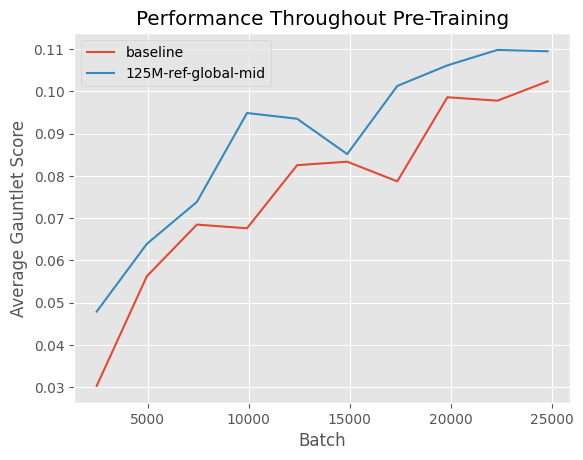

In [11]:
plt.style.use('ggplot')
print("| " + " | ".join(["average"] + metrics_to_report) + " |")
for run_name, step_metrics in runs_to_show.items():
    steps = sorted(step_metrics.keys())
    averages = []
    for step in steps:
        averages.append(np.mean(step_metrics[step][to_report_indices]))
        # averages.append(np.mean([metric[categories.index(metrics_to_report)] for metric in step_metrics[step]]))
    # averages = [step_metrics[step][0] for step in steps]
    plt.plot(steps, averages, label=groups[run_name])
    metrics = step_metrics[steps[-1]][to_report_indices].tolist()
    metrics = [f"{averages[-1]:.4f}"] + [f"{metric:.4f}" for metric in metrics]
    print(f"| {groups[run_name]} | {' | '.join(metrics)} |")
plt.legend()
plt.ylabel("Average Gauntlet Score")
plt.xlabel("Batch")
plt.title("Performance Throughout Pre-Training")
plt.show()

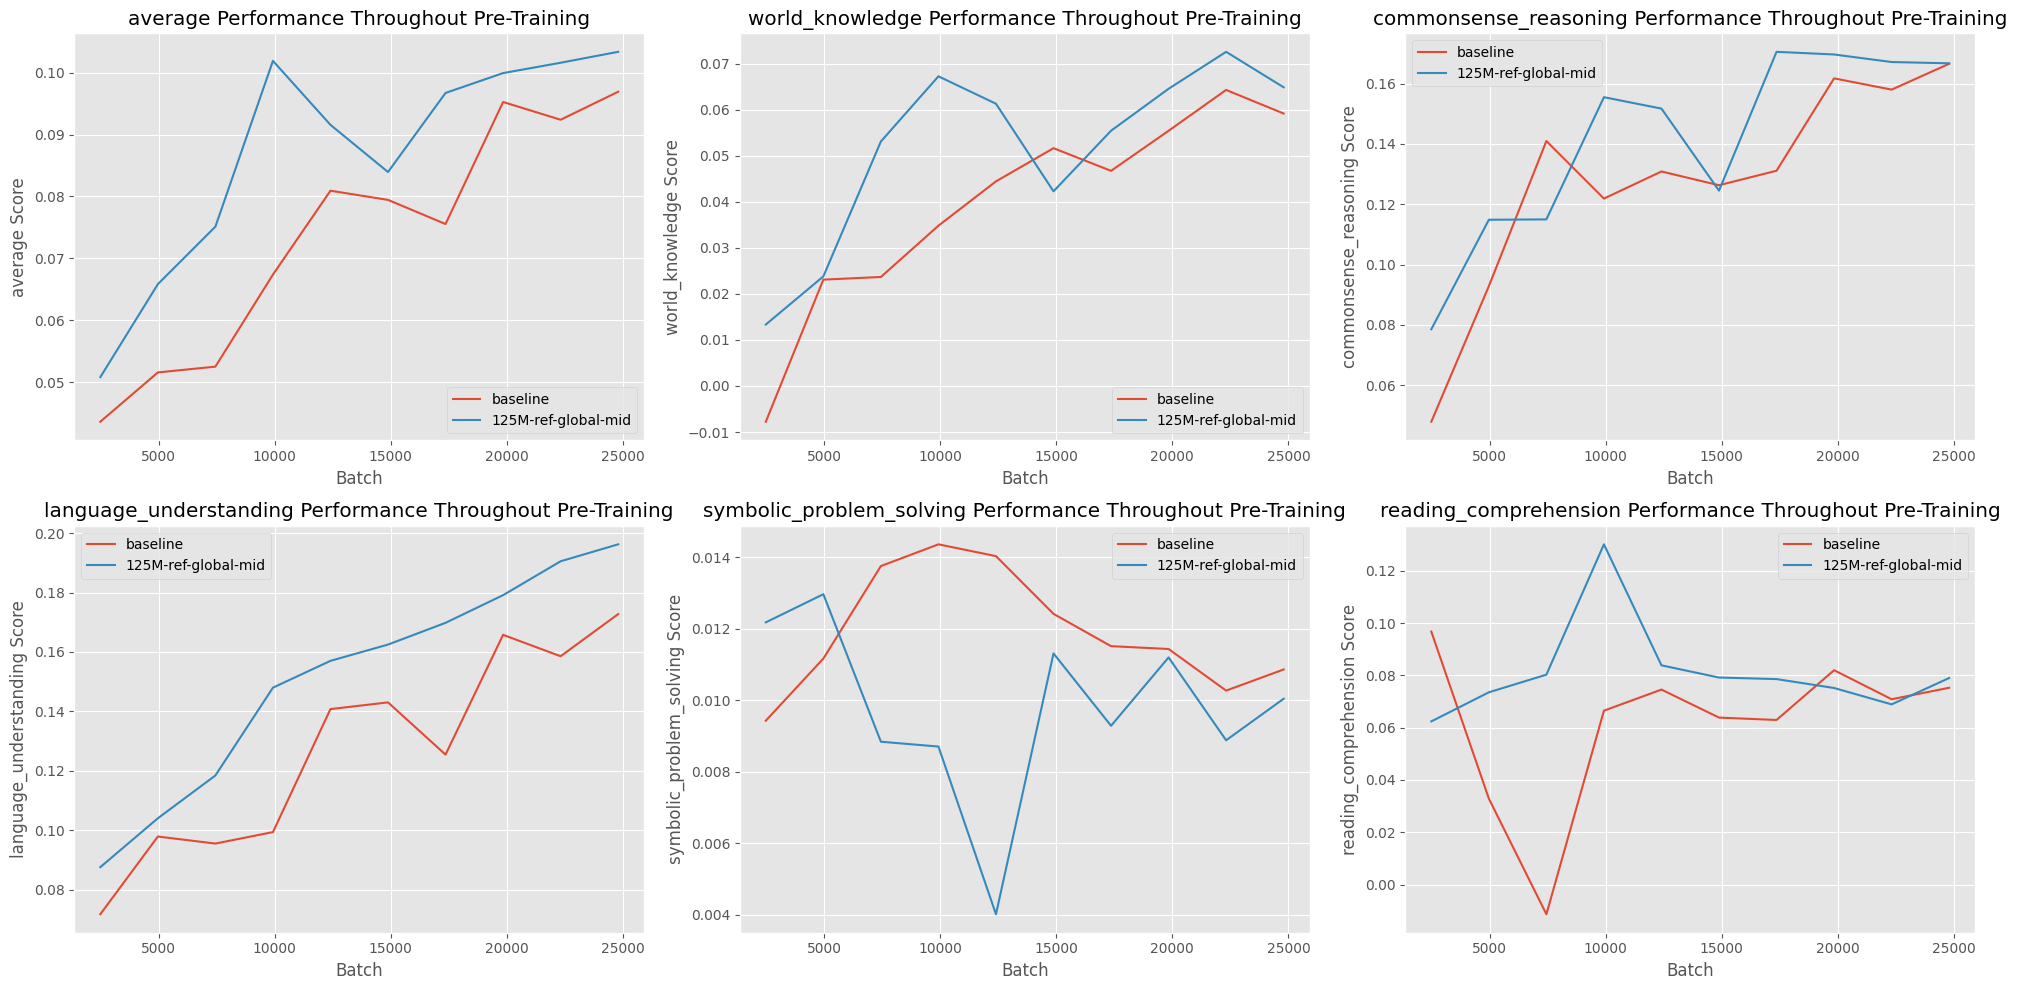

In [12]:
import math

# Calculate the number of rows needed for the subplots
rows = math.ceil(len(categories) / 3)

fig, axs = plt.subplots(rows, 3, figsize=(20, 5*rows))  # Create a grid of subplots

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Iterate over each category (metric)
for i, category in enumerate(categories):
    
    # Iterate over each run
    for run_name, step_metrics in runs_to_show.items():
        steps = sorted(step_metrics.keys())
        
        # Get the metric values for the current category
        metrics = [step_metrics[step][i] for step in steps]
        
        axs[i].plot(steps, metrics, label=groups[run_name])
    
    axs[i].legend()
    axs[i].set_ylabel(f"{category} Score")
    axs[i].set_xlabel("Batch")
    axs[i].set_title(f"{category} Performance Throughout Pre-Training")

# Remove any unused subplots
for i in range(len(categories), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()

# Save the figure to disk
plt.savefig("figs/web-gauntlet.png")

plt.show()